# AFM data analysis example using Nanite
***
**This notebook includes code from the example provided by Paul Müller in the [Nanite documentation](https://nanite.readthedocs.io/en/stable/sec_examples.html).**

Useful Resources:

* [Jupyter notebook shortcuts (remember to press Esc!)](https://shortcutworld.com/Jupyter-Notebook/win/Jupyter-Notebook_Shortcuts)

* [Nanite documentation](https://nanite.readthedocs.io/en/stable/)

In [2]:
# Install the nanite and seaborn package
import sys
!{sys.executable} -m pip install nanite     # AFM data analysis library
!{sys.executable} -m pip install seaborn    # Plotting library

In [10]:
# Import packages needed for the tutorial
import os                         # Operating system interfaces library
import glob                       # File path handling library
import nanite                     # AFM data analysis library
import numpy as np                # Numerical computing library
import seaborn as sns             # Plotting library
import matplotlib.pyplot as plt   # Plotting library

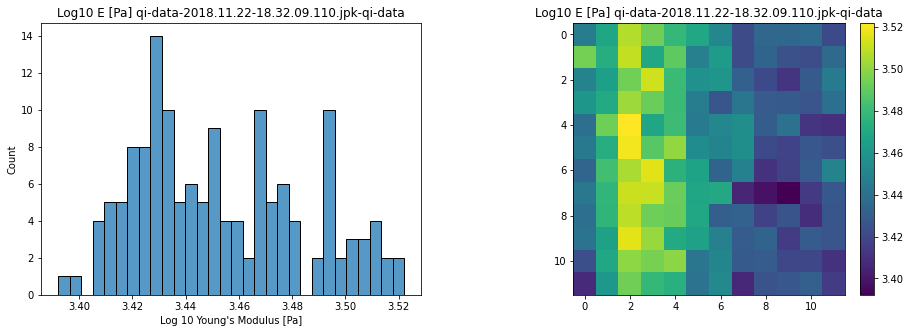

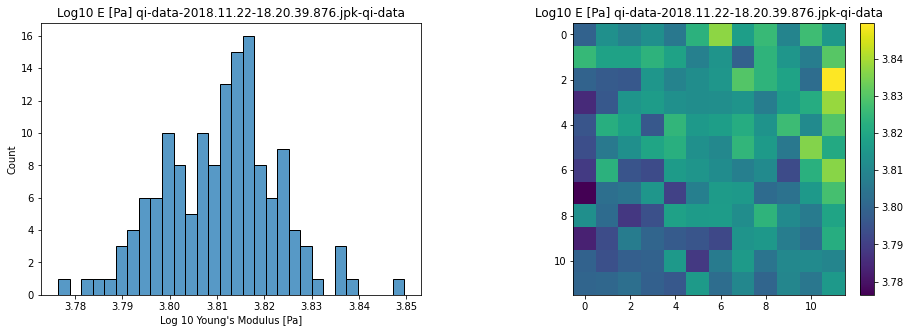

In [9]:
# Jupyter notebook magic method to include matplotlib plots next to our code.
%matplotlib inline

# Define file path variables
file_path = "./data_files/"
file_extension = "*.jpk-qi-data"

# Define data anaylsis variables
# Nanite documentation for finding model keys
# https://nanite.readthedocs.io/en/stable/sec_code_reference.html#models
model_to_fit = "hertz_para"
tip_radius = 18.64e-06 # meters

# Degine the number of bins for the histograms
n_bins = 30

# Iterate through the files and perform the analysis
for file_path in glob.glob(file_path + file_extension):
    
    # Get file name
    file_name = os.path.basename(file_path)
    
    # Load data from file path
    group = nanite.load_group(file_path)
    
    # Create list to output results
    results = []
    
    for idnt in group:
        
        # apply preprocessing
        idnt.apply_preprocessing(["compute_tip_position",
                                  "correct_force_offset",
                                  "correct_tip_offset"])
        
        # set the fit model
        idnt.fit_properties["model_key"] = model_to_fit
        
        # get the initial fit parameters
        params = idnt.get_initial_fit_parameters()
        
        # set the correct indenter radius
        params["R"].value = tip_radius
        
        # perform the fit with the edited parameters
        idnt.fit_model(params_initial=params)
        
        # obtain the Young's modulus
        emod = idnt.fit_properties["params_fitted"]["E"].value
        
        # Add results to the results dataframe
        results.append(emod)
    
    # Prepare plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot histogram
    # Seaborn histplot documentation: https://seaborn.pydata.org/generated/seaborn.histplot.html
    sns.histplot(np.log10(results), bins=n_bins, ax=axs[0])
    axs[0].set_title(f"Log10 E [Pa] {file_name}")
    axs[0].set_xlabel("Log 10 Young's Modulus [Pa]")
    
    # Plot young's modulus qmap
    # https://nanite.readthedocs.io/en/stable/sec_code_reference.html#module-nanite.qmap
    E_qmap_data = nanite.QMap(group).get_qmap("fit young's modulus", qmap_only=True)
    E_qmap = axs[1].imshow(np.log10(E_qmap_data[::-1]))
    axs[1].set_title(f"Log10 E [Pa] {file_name}")
    fig.colorbar(E_qmap, ax=axs[1], fraction=0.046, pad=0.04)
    
    # Display the plots
    plt.show()